# Fashion MNIST classification
Dataset: [GitHub](https://github.com/zalandoresearch/fashion-mnist), [Kaggle](https://www.kaggle.com/zalando-research/fashionmnist), [Tensorflow Datasets](https://www.tensorflow.org/datasets/catalog/fashion_mnist), [torchvision.datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#fashion-mnist). <br>
Цель – accuracy на тестовой выборке >= 0.88

In [1]:
from IPython.display import clear_output
!pip install pycodestyle pycodestyle_magic
!pip install flake8
clear_output()

In [2]:
%load_ext pycodestyle_magic

In [3]:
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from torchvision import datasets, transforms
from sklearn.metrics import classification_report

%matplotlib inline

In [4]:
torch.manual_seed(42)
np.random.seed(42)
clear_output()

# Данные и препроцессинг
Преобразуем данные в тензоры.

In [5]:
mnist_train = datasets.FashionMNIST('.', train=True,
                                    transform=transforms.ToTensor(),
                                    download=True)

mnist_test = datasets.FashionMNIST('.', train=False,
                                   transform=transforms.ToTensor(),
                                   download=True)

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100)

clear_output()

In [6]:
mnist_train

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
mnist_test

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: .
    Split: Test
    StandardTransform
Transform: ToTensor()

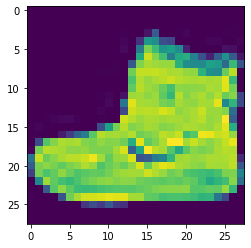

In [8]:
plt.imshow(mnist_train[0][0].numpy().reshape(28,28))

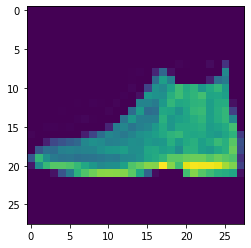

In [9]:
plt.imshow(mnist_test[0][0].numpy().reshape(28,28))

# Архитектура нейронной сети
2 слоя конволюции (активация – ReLU), 2 слоя пулинга, между ними 2 слоя batch нормализации, затем 3 dense слоя и между ними 1 дропаут.

In [10]:
class CNNModel(torch.nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )
        self.dense_1 = torch.nn.Linear(64 * 6 * 6, 600)
        self.dropout = torch.nn.Dropout2d(0.25)
        self.dense_2 = torch.nn.Linear(600, 120)
        self.dense_3 = torch.nn.Linear(120, 10)

    def forward(self, x):
        out = self.conv_1(x)
        out = self.conv_2(out)
        out = out.view(out.size(0), -1)
        out = self.dense_1(out)
        out = self.dropout(out)
        out = self.dense_2(out)
        out = self.dense_3(out)
        return out

# Обучение

In [11]:
model = CNNModel()

In [12]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 10

Чтобы не писать один и тот же кусок кода дважды, напишем функцию train_model, которую будем использовать и на обучающей, и на тестовой выборке (с аргументом train=True).

In [13]:
def train_model(model, loader, criterion, optimizer, train=True):
    curr_loss, curr_acc = 0.0, 0.0
    if train:
        model.train()
    else:
        model.eval()
    for X, y in loader:
        with torch.set_grad_enabled(train):
            y_pred = model(X)
        loss = criterion(y_pred, y)
        curr_loss += loss.item()
        curr_acc += (y_pred.argmax(dim=1) == y).sum().item()
        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return curr_loss / len(loader), curr_acc / len(loader.dataset)

In [14]:
train_losses = []
test_losses = []

for epoch in tqdm(range(1, n_epochs + 1)):
    start = time.time()
    train_loss, train_acc = train_model(model, train_loader, criterion,
                                        optimizer)
    test_loss, test_acc = train_model(model, test_loader, criterion, optimizer,
                                      train=False)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    stats = """
    Epoch: {}, time: {:.1f}s
    train_loss: {:.3f}, train_acc: {:.3f}\ttest_loss: {:.3f}, test_acc: {:.3f}
    """.format(epoch, time.time() - start, train_loss, train_acc,
               test_loss, test_acc)
    print(stats)

 10%|█         | 1/10 [01:46<15:56, 106.32s/it]


    Epoch: 1, time: 106.3s
    train_loss: 0.427, train_acc: 0.847	test_loss: 0.410, test_acc: 0.856
    


 20%|██        | 2/10 [03:31<14:08, 106.12s/it]


    Epoch: 2, time: 105.7s
    train_loss: 0.295, train_acc: 0.895	test_loss: 0.364, test_acc: 0.872
    


 30%|███       | 3/10 [05:19<12:25, 106.46s/it]


    Epoch: 3, time: 107.2s
    train_loss: 0.255, train_acc: 0.908	test_loss: 0.308, test_acc: 0.895
    


 40%|████      | 4/10 [07:05<10:38, 106.50s/it]


    Epoch: 4, time: 106.6s
    train_loss: 0.230, train_acc: 0.918	test_loss: 0.282, test_acc: 0.904
    


 50%|█████     | 5/10 [08:51<08:50, 106.18s/it]


    Epoch: 5, time: 105.4s
    train_loss: 0.208, train_acc: 0.925	test_loss: 0.300, test_acc: 0.901
    


 60%|██████    | 6/10 [10:36<07:03, 105.80s/it]


    Epoch: 6, time: 104.9s
    train_loss: 0.193, train_acc: 0.930	test_loss: 0.298, test_acc: 0.906
    


 70%|███████   | 7/10 [12:20<05:16, 105.47s/it]


    Epoch: 7, time: 104.7s
    train_loss: 0.179, train_acc: 0.935	test_loss: 0.282, test_acc: 0.908
    


 80%|████████  | 8/10 [14:05<03:30, 105.33s/it]


    Epoch: 8, time: 105.0s
    train_loss: 0.169, train_acc: 0.940	test_loss: 0.312, test_acc: 0.901
    


 90%|█████████ | 9/10 [15:50<01:45, 105.08s/it]


    Epoch: 9, time: 104.5s
    train_loss: 0.158, train_acc: 0.943	test_loss: 0.339, test_acc: 0.899
    


100%|██████████| 10/10 [17:34<00:00, 105.47s/it]


    Epoch: 10, time: 104.4s
    train_loss: 0.148, train_acc: 0.948	test_loss: 0.332, test_acc: 0.904
    


Baseline легко побит, test_acc – 0.904!

# Оценка качества
Построим график loss-ов для обучающей и тестовой выборки

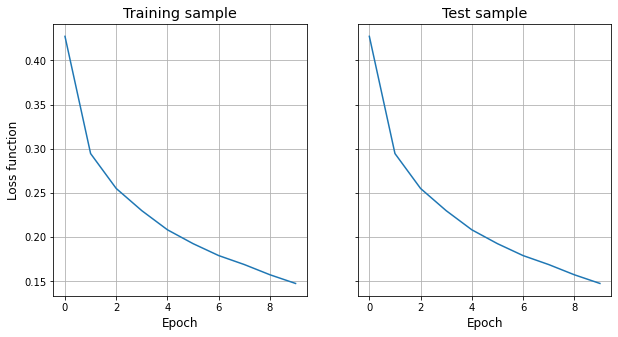

In [15]:
fig, (ax_1, ax_2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
ax_1.plot(train_losses)
ax_2.plot(train_losses)
ax_1.grid(True)
ax_2.grid(True)
ax_1.set_xlabel('Epoch', fontsize='large')
ax_2.set_xlabel('Epoch', fontsize='large')
ax_1.set_ylabel('Loss function', fontsize='large')
ax_1.set_title('Training sample', fontsize='x-large')
ax_2.set_title('Test sample', fontsize='x-large')
plt.show()

Посмотрим на метрики качества.

In [16]:
stats = """Final accuracy on test sample: {:.3f}
Final loss on training sample: {:.3f}
Final loss on test sample: {:.3f}""".format(test_acc, train_losses[-1],
                                            test_losses[-1])
print(stats)

Final accuracy on test sample: 0.904
Final loss on training sample: 0.148
Final loss on test sample: 0.332


Построим classification report на тестовой выборке.

In [29]:
y_true = []
y_pred = []

model.eval()
for X, y in test_loader:
    y_true.append(y.numpy())
    y_pred.append(model(X).argmax(dim=1).numpy())

In [33]:
y_true = list(chain.from_iterable(y_true))
y_pred = list(chain.from_iterable(y_pred))

In [34]:
target_names = ['T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                 'Sandal', 'Shirt', 'Sheaker', 'Bag', 'Ankle boot']

print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 T-shirt/Top       0.77      0.93      0.84      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.86      0.86      0.86      1000
       Dress       0.86      0.94      0.90      1000
        Coat       0.89      0.78      0.83      1000
      Sandal       0.99      0.98      0.98      1000
       Shirt       0.83      0.63      0.72      1000
     Sheaker       0.96      0.98      0.97      1000
         Bag       0.93      0.99      0.96      1000
  Ankle boot       0.98      0.97      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.91      0.90      0.90     10000
weighted avg       0.91      0.90      0.90     10000

